In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
import keras
print(keras.__version__)

3.1.1


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
import keras
print(keras.__version__)

3.1.1


In [7]:
! nvidia-smi

Thu Jun  6 20:36:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
! pip install opencv-python
! pip install pydicom  
! pip install pandas
! pip install scikit-learn
! pip install seaborn

In [8]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
from tensorflow.keras.applications import efficientnet_v2
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

In [9]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [10]:
EPOCHS = 70
BATCH_SIZE = 8
LR = 0.001
SAVE_BEST = True
MODEL_CLASS = 'v2s'

In [11]:
base_path = '/kaggle/input/osic-pulmonary-fibrosis-progression/'
train = pd.read_csv(base_path + 'train.csv')

In [12]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [13]:
train.tail()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked
1548,ID00426637202313170790466,59,2774,68.117081,73,Male,Never smoked


In [14]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [15]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [16]:
A = {} 
TAB = {} 
P = [] 
for i, p in enumerate(train.Patient.unique()):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/tmp/ipykernel_34/2116535558.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, b = np.linalg.lstsq(c, fvc)[0]


In [18]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (300, 300))

In [19]:
x, y = [], []
for p in train.Patient.unique():
    try:
        #/kaggle/input/osic-pulmonary-fibrosis-progression-lungs-mask
        ldir = os.listdir(f'/kaggle/input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/{p}/')
        numb = [float(i[:-4]) for i in ldir]
        for i in ldir:
            x.append(cv2.imread(f'/kaggle/input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/{p}/{i}', 0).mean())
            y.append(float(i[:-4]) / max(numb))
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/kaggle/input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/ID00011637202177653955184/'
[Errno 2] No such file or directory: '/kaggle/input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/ID00052637202186188008618/'


In [20]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'{base_path}train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'{base_path}train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return (x,tab), a

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Concatenate, Dropout, GRU, Reshape, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.applications import efficientnet_v2

def get_efficientnetv2(model, shape):
    models_dict = {
        'v2b0': efficientnet_v2.EfficientNetV2B0(input_shape=shape,weights=None,include_top=False),
        'v2b1': efficientnet_v2.EfficientNetV2B1(input_shape=shape,weights=None,include_top=False),
        'v2b2': efficientnet_v2.EfficientNetV2B2(input_shape=shape,weights=None,include_top=False),
        'v2b3': efficientnet_v2.EfficientNetV2B3(input_shape=shape,weights=None,include_top=False),
        'v2s': efficientnet_v2.EfficientNetV2S(input_shape=shape,weights=None,include_top=False),
        'v2m': efficientnet_v2.EfficientNetV2M(input_shape=shape,weights=None,include_top=False),
        'v2l': efficientnet_v2.EfficientNetV2L(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]


def build_model(shape=(300, 300, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnetv2(model_class, shape)
    x = base(inp)
    print(x.shape)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x2 = tf.keras.layers.Reshape((4,1),input_shape=(4,))(x2)
    x2 = tf.keras.layers.GRU(128, return_sequences=True)(x2)
    x2 = tf.keras.layers.Reshape((512,),input_shape=(4,128,))(x2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.3)(x) 
    x = Dense(1)(x)
    model = Model(inputs=(inp, inp2), outputs=x)
    #model = Model(inp , x)
    return model

# Training

In [22]:
P = np.array(P)
subs = []
folds_history = []
    
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'effnetv2s_new_{EPOCHS}.keras',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)
model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit(IGenerator(keys=P, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 16, 
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training done!')

(None, 10, 10, 1280)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70


2024-06-06 20:48:33.497792: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 6.0618
Epoch 1: val_loss improved from inf to 9.21465, saving model to effnetv2s_new_70.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 563ms/step - loss: 6.0447 - val_loss: 9.2146 - learning_rate: 0.0010
Epoch 2/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 4.3746
Epoch 2: val_loss improved from 9.21465 to 3.82176, saving model to effnetv2s_new_70.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - loss: 4.3702 - val_loss: 3.8218 - learning_rate: 0.0010
Epoch 3/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 4.3959
Epoch 3: val_loss did not improve from 3.82176
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - loss: 4.3914 - val_loss: 4.1220 - learning_rate: 0.0010
Epoch 4/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 4.2054
Epoch 4: val_loss did not improve from 3.82176
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - loss: 4.2126 - val_loss: 4.1331 - learning_rate: 0.0010
Epoch 5/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 4.0697
Epoch

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 32: val_loss did not improve from 3.42395
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 4.6252 - val_loss: 4.4352 - learning_rate: 6.2500e-05
Epoch 33/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 3.7024
Epoch 33: val_loss did not improve from 3.42395
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - loss: 3.7162 - val_loss: 4.2052 - learning_rate: 6.2500e-05
Epoch 34/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 5.5496
Epoch 34: val_loss did not improve from 3.42395
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - loss: 5.5365 - val_loss: 3.9634 - learning_rate: 6.2500e-05
Epoch 35/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 5.3251
Epoch 35: val_loss did not improve from 3.42395

Epoch 35: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - loss: 5.3119 - val_loss: 4.8093 - learning_rate: 6.2500e-05
Epoch 36/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 4.6923
Epoch 36: val_loss did not improve from 3.4239

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 4)         │          0 │ input_layer_8[0]… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 1)      │          0 │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-s    │ (None, 10, 10,    │ 20,330,928 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 4, 128)    │     50,304 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-s… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 512)       │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1792)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      1,793 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,841,333 (232.09 MB)

 Trainable params: 20,229,153 (77.17 MB)

 Non-trainable params: 153,872 (601.06 KB)

 Optimizer params: 40,458,308 (154.34 MB)

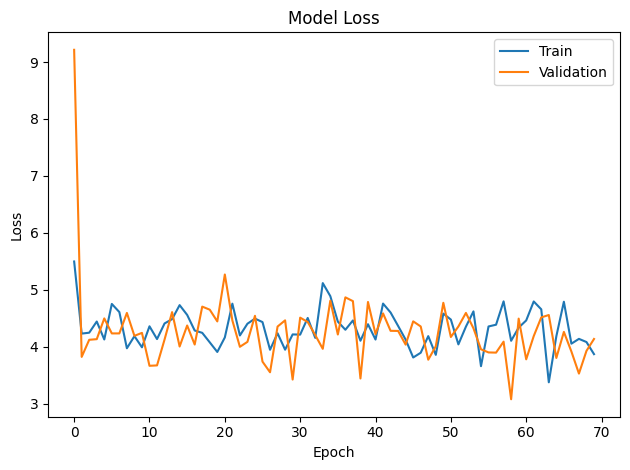

In [24]:
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [25]:
%cd /kaggle/working/

/kaggle/working


In [26]:
from IPython.display import FileLink 
FileLink(r'effnetv2s_new_70.keras')

/kaggle/working/effnetv2s_new_70.keras